<a href="https://colab.research.google.com/github/dvirbz/NLP2025/blob/main/HW2/NLP_HW2_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div dir=rtl>

# עיבוד שפה טבעית (20225211) 2024-2025 - תרגיל 2 שאלה 3 (4 נק' מתוך 8)

שלום לכולםן!

התרגיל שלהלן יתבסס במידה רבה על ההדרכה שעברתןם ב-3/12 ויעקוב באופן כללי אחרי אותם שלבים - ניתן ומומלץ להיעזר ב[מחברת ההדרכה](https://colab.research.google.com/drive/1CVllovh2b6AXCNr6amTNamB9lEttY385?usp=sharing). המטרה היא לבנות רשת נשנית שמתייגת חלקי דיבר עבור השפה טלוגו.

בסיום העבודה, הגישו **קובץ pdf** הכולל את כל הפלטים מכל התאים. דרך אפשרית אחת להשיג קובץ pdf היא על-ידי הדפסת הדף (מתוך colab, לא מהדפדפן) ולבחור "מדפסת" ישירה ל-pdf. אני מזכיר שמועד ההגשה עבור כל חלקי התרגיל הינו 16/12/24, 15:59.

בהצלחה,

-- יובל

</div>

<div dir=rtl>

# התקנות

כמו במקרה הקודם, נוכל להשתמש בחבילות עיבוד השפה של [האגינגפייס](https://huggingface.co/) על-מנת לטעון את הדאטא.
כיוון שאנחנו טוענים דאטא בפורמט מטוקנז של יוניברסל דפנדנסיז (UD), נצטרך להתקין גם חבילה התומכת בו.
אפשר להתעלם מהתקלה שהוא מצהיר עליה.

</div>

In [58]:
!pip install datasets -q
!pip install tokenizers -q
!pip install conllu -q
!pip install optuna -q

<div dir=rtl>

# ייבוא

נצטרך כמעט את כל החבילות שהתקנו עבור הרשת הנשנית למסמכים.

</div>

In [59]:
import matplotlib.pyplot as plt  # for plotting
import pandas as pd  # only to show some data in a nice table
import torch
import optuna

from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import WhitespaceSplit
from tokenizers.trainers import WordLevelTrainer

from datasets import load_dataset
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm  # progress bar

<div dir=rtl>

# זרע הפורענות

משהו שכדאי לעשות בזמן שמפתחים מודל הוא להמעיט באקראיות ככל הניתן.
בחבילות הנומריות של פייתון כמו numpy ו-pytorch יש הרבה מאוד אלמנטים אקראיים, כמו איך פרמטרים מאותחלים, או באיזה סדר נופל דאטאסט אם אנחנו בוחרים לערבב אותו בכל איטרציה (מומלץ באופן כללי, לא נממש הפעם).
הדרך שלנו לשלוט באלמנטים האלה כדי שיהיו זהים בכל הרצה (ובין היתר, להקל על בדיקת התרגיל) היא לקבוע זרע אקראי בתחילת ההרצה, שממנו תנבע האקראיות באופן דטרמיניסטי. הבה:

</div>

In [60]:
SEED = 5785

import random
from numpy import random as nprnd

random.seed(SEED)
nprnd.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

<div dir=rtl>

# מה בדאטא?

כמו בניתוח סנטימנט, אנחנו רוצים לדעת עם מה יש לנו עסק. לטעון מתוך UD זה קל עם חבילת datasets, ובשביל לגשת לשדות השונים, ניתן להיעזר ב[דף התיעוד](https://huggingface.co/datasets/universal_dependencies).
אותנו מעניין רק הטקסט וחלקי הדיבר UPOS (בשלב הזה) ולכן נסתכל על כמה דוגמאות:

</div>

In [61]:
pd.set_option('display.max_colwidth', None)
dataset = load_dataset(
   'universal_dependencies', 'te_mtg', trust_remote_code=True)
dataset.set_format(type="pandas", columns=["text", "tokens", "upos"])
dataset['validation'][:10]

,text,tokens,upos
0,మనం ఎందుకు అన్నం తింటాం ?,"[మనం, ఎందుకు, అన్నం, తింటాం, ?]","[11, 14, 0, 16, 1]"
1,నువ్వు పని చెయ్యాలి .,"[నువ్వు, పని, చెయ్యాలి, .]","[11, 0, 16, 1]"
2,నేను ఆ పని చెయ్యాల్సి వచ్చింది .,"[నేను, ఆ, పని, చెయ్యాల్సి, వచ్చింది, .]","[11, 8, 0, 16, 16, 1]"
3,మీ తల్లిదండ్రుల ఊరు ఏమిటి ?,"[మీ, తల్లిదండ్రుల, ఊరు, ఏమిటి, ?]","[11, 0, 0, 11, 1]"
4,అవి మా ఇళ్ళ గోడలు .,"[అవి, మా, ఇళ్ళ, గోడలు, .]","[11, 11, 0, 0, 1]"
5,ఇది పళ్ళ బుట్ట .,"[ఇది, పళ్ళ, బుట్ట, .]","[11, 0, 0, 1]"
6,ఇవ్వేళ ఆమె ఇక్కడ లేదు .,"[ఇవ్వేళ, ఆమె, ఇక్కడ, లేదు, .]","[0, 11, 14, 16, 1]"
7,నిన్న మేము ఊళ్ళో లేము .,"[నిన్న, మేము, ఊళ్ళో, లేము, .]","[14, 11, 0, 16, 1]"
8,దుకాణాల్లో బియ్యం లేవు .,"[దుకాణాల్లో, బియ్యం, లేవు, .]","[0, 0, 16, 1]"
9,అతను నన్ను వెళ్ళమన్నాడు .,"[అతను, నన్ను, వెళ్ళమన్నాడు, .]","[11, 11, 16, 1]"


<div dir=rtl>

המממ. קצת פחות ברור מה שקורה פה מאשר בדוגמת המסמכים השלמים. קודם כל, אנחנו לא דוברים טלוגו. [הנה](https://en.wikipedia.org/wiki/Telugu_language) ערך הויקיפדיה שלה, ו[הנה](https://wals.info/languoid/lect/wals_code_tel) הערך שלה ב-WALS, משאב טיפולוגי שסקרנו בשיעורי המבוא. WALS יספר לנו על תכונות של השפה שאולי יעזרו לנו להבין בהמשך אם יש תופעות שכדאי להתייחס אליהן מפורשות.

הדבר השני שאנחנו מתקשים איתו הוא פורמט התגים, שמופיעים כאן אחרי שכבר מופו לאינדקסים ע"י מי שהזין אותם לשרתי האגינגפייס. למזלנו, דאגו לנו גם לשמירת המיפוי בתוך הדאטאסט, וניתן לגשת אליו מתוך כל אחד מחיתוכי הדאטא (splits).

</div>

In [62]:
val_tags = dataset['validation'].features['upos'].feature.names
[f'{i:2}: {p}' for (i,p) in enumerate(val_tags)]

[' 0: NOUN',
 ' 1: PUNCT',
 ' 2: ADP',
 ' 3: NUM',
 ' 4: SYM',
 ' 5: SCONJ',
 ' 6: ADJ',
 ' 7: PART',
 ' 8: DET',
 ' 9: CCONJ',
 '10: PROPN',
 '11: PRON',
 '12: X',
 '13: _',
 '14: ADV',
 '15: INTJ',
 '16: VERB',
 '17: AUX']

<div dir=rtl>

סקירת-שפיות קצרה של הדאטא מהתא הקודם תראה לנו שבאמת ברוב המשפטים יש פועל (16), כפי שאנו מצפים מכל שפה, שיש הרבה שמות עצם (0), ושסימני הפיסוק מקבילים לתג המתאים (1).

1. רשמו את קוד התכונה (Fid) מערך ה-WALS שבזכותו אנחנו לא מופתעיםות ממיקומי הפעלים שראינו במשפטי הדוגמה.

</div>

<div dir=rtl>

---

**81A**

---


</div>

<div dir=rtl>

כיוון שאנחנו חשדניםות מטבענו, ולא נרצה שנאמן את המודל על רשימת תגים מסוימת ואח"כ נבחן אותו על אינדקסים לא-תואמים (מה שיכול לגרום לכך שכל החיזויים שלנו לשמות עצם יפורשו כחיזויים לפעלים, למשל), נכתוב קוד קצר שמוודא שסדר התגים זהה עבור אימון, ולידציה ומבחן.

2. כתבו קוד שמוודא את סדר התגים לשלושת חלקי הדאטאסט. ניתן להשתמש בפונקציית `assert`.
**מגישים.ות ביחיד.ה פטוריםות מהסעיף**

</div>

In [63]:
### for exercise 2 ###

train_tags = dataset['train'].features['upos'].feature.names
test_tags = dataset['test'].features['upos'].feature.names
ordered_val_tags = [f'{i:2}: {p}' for (i,p) in enumerate(val_tags)]
ordered_train_tags = [f'{i:2}: {p}' for (i,p) in enumerate(train_tags)]
ordered_test_tags = [f'{i:2}: {p}' for (i,p) in enumerate(test_tags)]
assert ordered_train_tags == ordered_val_tags == ordered_test_tags
print(f"{ordered_train_tags=}\n{ordered_test_tags=}\n{ordered_val_tags=}")
###

ordered_train_tags=[' 0: NOUN', ' 1: PUNCT', ' 2: ADP', ' 3: NUM', ' 4: SYM', ' 5: SCONJ', ' 6: ADJ', ' 7: PART', ' 8: DET', ' 9: CCONJ', '10: PROPN', '11: PRON', '12: X', '13: _', '14: ADV', '15: INTJ', '16: VERB', '17: AUX']
ordered_test_tags=[' 0: NOUN', ' 1: PUNCT', ' 2: ADP', ' 3: NUM', ' 4: SYM', ' 5: SCONJ', ' 6: ADJ', ' 7: PART', ' 8: DET', ' 9: CCONJ', '10: PROPN', '11: PRON', '12: X', '13: _', '14: ADV', '15: INTJ', '16: VERB', '17: AUX']
ordered_val_tags=[' 0: NOUN', ' 1: PUNCT', ' 2: ADP', ' 3: NUM', ' 4: SYM', ' 5: SCONJ', ' 6: ADJ', ' 7: PART', ' 8: DET', ' 9: CCONJ', '10: PROPN', '11: PRON', '12: X', '13: _', '14: ADV', '15: INTJ', '16: VERB', '17: AUX']


<div dir=rtl>

# טוקנייזר

בעית הטיקנוז שלנו קלה אפילו יותר מזו שהיתה בניתוח סנטימנט. המסמכים שלנו באים עם חלוקה לטוקנים מראש, ולכן אפשר פשוט להעביר לטוקנייזר שנבנה בתור ברירת מחדל את הפרמטר לפיו המידע שהוא מקבל כבר עבר "טרום-טוקניזציה".
על-כן:
1. נטען את הדאטאסט
1. ניצור טוקנייזר פשוט
1. נגדיר לו את התמנית הלא ידועה `UNK` ואת תמנית הריפוד `PAD`
1. נאמן את הטוקנייזר
1. נספר לו איך לרפד.

אחר-כך נצטרך לטפל גם בטוקנייזר עבור התגים, בעיקר כדי לשמור על מדיניות ריפוד אחידה (המודולים ב-`torch` יצפו לאורך רצפים אחידים בין הקלט לתגים).
בשני המקרים נעשה משהו קצת מלוכלך בשביל ליצור לטוקנייזר מחרוזת כקלט. עבור הטוקנים, נגדיר פונקציה שמכניסה רווחים שאחר-כל האימון של הטוקנייזר יוציא, ועבוד התגים, כיוון שהם נטענו בפורמט `int`, נריץ עליהם פונקציית `str()`.

</div>

In [64]:
PAD_ID = 0

def map_instance_to_whitespace_tokenizable_text(inst) -> str:
    return " ".join(inst['tokens'])

def make_tokenizers():
    dataset = load_dataset("universal_dependencies", "te_mtg", split="train")
    tokenizer = Tokenizer(WordLevel(unk_token="<UNK>"))
    tokenizer.pre_tokenizer = WhitespaceSplit()
    trainer = WordLevelTrainer(special_tokens=["<PAD>", "<UNK>"])
    tokenizer.train_from_iterator([map_instance_to_whitespace_tokenizable_text(i) for i in dataset],
                                  trainer=trainer,
                                  length=len(dataset))
    tokenizer.enable_padding(pad_id=PAD_ID, pad_token="<PAD>")

    tag_tokenizer = Tokenizer(WordLevel(vocab={str(i): i for i in range(len(val_tags)+1)}))
    tag_tokenizer.enable_padding(pad_id=len(val_tags), pad_token=str(len(val_tags)))
    return tokenizer, tag_tokenizer

In [65]:
tokenizer, tag_tokenizer = make_tokenizers()

tokenizer.save("ud-te-tokenizer.json", pretty=True)
tag_tokenizer.save("ud-te-tag-tokenizer.json", pretty=True)

print(tokenizer.get_vocab_size())
print(tag_tokenizer.get_vocab_size())

1745
19


<div dir=rtl>

שימו לב שקיבלנו אוצר מילים די קטן לטוקנים, כיאה לדאטאסט קטן. הולכים להיות לנו הרבה מאוד `UNK` בולידציה ובטסט.
19 תגים זה המספר הרצוי, שכן יש 18 תגים בסכימת UPOS, והוספנו תג ריפוד.

</div>

<div dir=rtl>

# בניית מתייג חלקי דיבר

נתחיל בהמרת המעבד שלנו ל-GPU:

</div>

In [66]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

<div dir=rtl>

## הגדרת המודל

המודל הבסיסי שלנו זהה לזה שהשתמשנו בו עבור הרשת לסיווג טקסט שלם, עם הבדל אחד מאוד חשוב: הפלט שלה צריך להיות ברמת הטוקן; לא לוקחים רק את האחרון אלא את כל הסט שיוצא מה-LSTM, ואותו מעבירים לשכבה לינארית.

**שימו לב:** בהמשך נראה שפונקציית ההפסד שלנו מקבלת ציונים לא-מנורמלים עבור הקלאסים (חלקי דיבר, במקרה שלנו) ומבצעת את ה-`softmax` כחלק מהחישוב. אל תעבירו את הפלט בפונקציה שמבצעת חישוב דומה.

3. ממשו את `__init__()` ואת `forward()`. שימו לב לפרמטרים שהשתנו ביחס להדרכת תיוג המסמכים.

![](https://discuss.pytorch.org/uploads/default/original/2X/e/e7496a33d835f085d800ee17c0ade05895a89551.png)<br>

</div>

In [67]:
class PosTagger(nn.Module):
    def __init__(self,
                 embedding_dim: int,
                 hidden_size: int,
                 num_tags: int,
                 num_layers: int) -> None:
        super().__init__()

        ### for exercise 3.1 ###
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_tags = num_tags
        self.num_layers = num_layers

        self.embedding = nn.Embedding(tokenizer.get_vocab_size(),
                                      embedding_dim,
                                      padding_idx=tokenizer.padding["pad_id"])

        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=False)
        self.fc = nn.Linear(hidden_size, num_tags)
        # self.softmax = nn.Softmax(dim=2)
        ###


    def forward(self, x) -> torch.Tensor:
        ### for exercise 3.2 ###
        embed = self.embedding(x)
        output, _ = self.lstm(embed)
        out = self.fc(output)
        # out = self.softmax(out)
        return out

<div dir=rtl>

## אימון ו-ולידציה

ההבדל העיקרי בפרקטיקת האימון אל מול סיווג מסמכים היא שיש גרדיאנט שמחושב עבור כל אחד מהטוקנים בנפרד: לכל אצווה (batch) יהיו לנו מספר תחזיות לא כגודלה אלא כסכום אורכי המשפטים שבה.
עיינו בקפידה ב[תיעוד](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) מודול ההפסד שנשתמש בו וחישבו היטב מה הקלט שלו צריך להיות.

4.1 ממשו את חישוב ההפסד ופעפועו. שימו לב לגדלי הטנסורים המשתתפים. שני רמזים בהקשר זה:
* אין לדאוג עדיין לטוקני הריפוד. אנחנו לא נרצה להשתמש בתחזיות שלהם כמובן, אבל הטיפול בהם קורה בשלב אתחול ההפסד.
* גשו לתיעוד של `torch.tensor` ועמדו על ההבדל בין הפעולות `view()` ו-`permute()`.
* **מגישים ביחיד.ה פטוריםות מהסעיף - פנו אליי עד ליום 10/12 בשעה 13:59 לקבלת שורות הקוד (מילואימניקים עד 14/12 ב-23:59).**

4.2. ממשו את חישוב המטריקה. אנו נמדוד דיוק פשוט (accuracy), ולצורך כך אותחלו עבורכם משתני-עזר לפני הלולאה. כאן אנחנו כן דואגים לטוקני הריפוד.

</div>

In [68]:
def train(model: PosTagger,
          optimizer: optim.Optimizer,
          loss_fn: nn.CrossEntropyLoss,
          dataloader: DataLoader) -> dict:
    model.train()
    total = 0
    correct = 0
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        sentences = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        probs = model(sentences)
        ### for exercise 4.1 ###
        softmax = nn.Softmax(dim=2)
        probs = softmax(probs)
        probs = probs.permute((0,2,1))
        ###

        loss = loss_fn(probs, labels)
        loss.backward()
        optimizer.step()



        ###
        preds = probs.argmax(dim=1)
        preds = preds[labels != 18].view(-1)
        labels = labels[labels != 18].view(-1)
        ### for exercise 4.2 ###
        N = labels.shape[0]
        total += N
        current_correct = (preds == labels).sum()
        correct += current_correct
        ###

    return correct / total


def evaluate(model: PosTagger,
             dataloader: torch.utils.data.DataLoader) -> dict:
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():  # operations done in this block will not contribute to gradients
        for batch in tqdm(dataloader, desc="Evaluation"):
            sentences = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            probs = model(sentences)
            probs = probs.permute((0,2,1))
            preds = probs.argmax(dim=1)
            ### for exercise 4.2 ###
            preds = preds[labels!= 18].view(-1)
            labels = labels[labels != 18].view(-1)
            N = labels.shape[0]
            total += N
            current_correct = (preds == labels).sum()
            correct += current_correct
            ### (the same code from train() should work)

    return correct / total

<div dir=rtl>

# רגע האמת

נחבר הכל ביחד. נגדיר את הקבועים שלנו, שבהמשך יהיו היפר-פרמטרים.

</div>

In [69]:
BATCH_SIZE = 24
EMB_DIM = 100
HIDDEN_DIM = 128
NUM_LAYERS = 2
EPOCHS = 5

<div dir=rtl>

נגדיר פונקציית-עזר לחילוץ מחרוזות האינדקסים מתוך מיפויי התגים, ונטען בעזרתה את הדאטאסט.

</div>

In [70]:
def deep_stringify(x):
    if type(x) == int:
        return str(x)
    return [deep_stringify(a) for a in x]

dataset = load_dataset("universal_dependencies", "te_mtg")
dataset = dataset.map(lambda ins: {
    "input_ids": [e.ids for e in tokenizer.encode_batch(ins['tokens'],
                                                        is_pretokenized=True)],
    "labels": [e.ids for e in tag_tokenizer.encode_batch(deep_stringify(ins['upos']),
                                                        is_pretokenized=True)],
}, batched=True, batch_size=BATCH_SIZE)
dataset.set_format(type="torch", columns=["input_ids", "labels"], )

train_dataloader = DataLoader(dataset["train"], batch_size=BATCH_SIZE)
val_dataloader = DataLoader(dataset["validation"], batch_size=BATCH_SIZE)
test_dataloader = DataLoader(dataset["test"], batch_size=BATCH_SIZE)

<div dir=rtl>

נאתחל מודל, מאפטם ופונקציית הפסד.

5. אתחלו את פונקציית ההפסד.

</div>

pad_id=18


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1:
Training Accuracy: 26.86%
Validation Accuracy: 42.90%


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2:
Training Accuracy: 45.89%
Validation Accuracy: 50.00%


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3:
Training Accuracy: 58.91%
Validation Accuracy: 60.42%


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4:
Training Accuracy: 63.56%
Validation Accuracy: 62.99%


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5:
Training Accuracy: 67.89%
Validation Accuracy: 65.41%


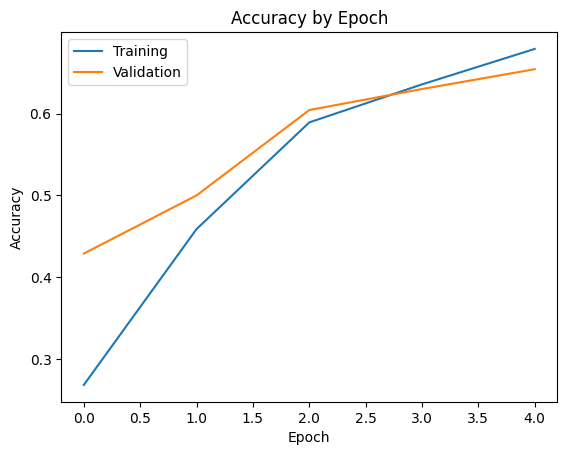

In [71]:
model = PosTagger(embedding_dim=EMB_DIM,
                  hidden_size=HIDDEN_DIM,
                  num_layers=NUM_LAYERS,
                  num_tags=len(val_tags)).to(device)
optimizer = optim.Adam(model.parameters())

### for exercise 5
pad_id = 18
print(f"{pad_id=}")
loss_fn = nn.CrossEntropyLoss(ignore_index = pad_id)

###

train_accuracies = []
validation_accuracies = []
for epoch in range(EPOCHS):
    train_acc = train(model, optimizer, loss_fn,
                          train_dataloader)
    val_acc = evaluate(model, val_dataloader)
    print(f"Epoch {epoch + 1}:")
    print(f"Training Accuracy: {100 * train_acc:.2f}%")
    print(f"Validation Accuracy: {100 * val_acc:.2f}%")
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracies, label="Training")
plt.plot(validation_accuracies, label="Validation")
plt.legend();

<div dir=rtl>

# ניתוח

6. בתיבת הטקסט להלן, תארו את הגרף שיצא לכםן לעיל. הציעו לפחות שני שינויים בהיפר-פרמטרים שלדעתכןם עשויים לשפר את התוצאה **וממשו אותם**. לכל ניסוי שכפלו את תיבת הקוד לעיל, שנו את מה שצריך, והריצו מחדש. **השתמשו בשמות משתנים חדשים עבור המודלים והתוצאות**. ניתן לוותר על הדפסות המספרים באפוקי הביניים ולהסתפק בתוצאות הסוף ובגרף.

7. שנו מאפיין של הניסוי ש**אינו** אחד מההיפר-פרמטרים המוגדרים. למשל, השתמשו בקלאס אחר מ-pytorch עבור הרשת הנשנית, המאפטם, או משהו אחר לבחירתכןם. או הוסיפו שכבה לינארית למודל.
**מגישים ביחיד.ה פטוריםות מסעיף 7**

האם השינויים אכן הועילו?

</div>

## תשובות
על מנת למצוא מודל טוב יותר השתמשנו בoptuna על מנת למצוא את ההיפר פרמטרים הטובים ביותר על סט הולידציה. \\
בנוסף הוספנו להיפר פרמטרים שינוי ל-bidirectional lstm. \\
שיפור נוסף שלא הספקנו לעשות תחת מגבלות הזמן הוא הוספה של sliding window validation על ה-validation set כדי למצוא את המודל הטוב ביותר. \\
בסעיף 8 נדווח את המודל הטוב ביותר שמצאנו.


In [72]:
## 2nd model with a bidirectional lstm
class PosTagger2(nn.Module):
    def __init__(self,
                 embedding_dim: int,
                 hidden_size: int,
                 num_tags: int,
                 num_layers: int) -> None:
        super().__init__()

        ### for exercise 3.1 ###
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_tags = num_tags
        self.num_layers = num_layers

        self.embedding = nn.Embedding(tokenizer.get_vocab_size(),
                                      embedding_dim,
                                      padding_idx=tokenizer.padding["pad_id"])

        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, num_tags)
        ###


    def forward(self, x, tags=None) -> torch.Tensor:
        ### for exercise 3.2 ###
        embed = self.embedding(x)
        lstm_out, _ = self.lstm(embed)
        out = self.fc(lstm_out)
        return out

In [73]:
### for exercise 6-7 ### disabled since it requires a lot of computational power
# def objective(trial):
#   EMB_DIM = trial.suggest_categorical('EMB_DIM', range(10, 1501, 10))
#   hid_dims = [2 ** i for i in range(4, 10)]
#   HIDDEN_DIM = trial.suggest_categorical('HIDDEN_DIM', hid_dims)
#   MODEL2 = trial.suggest_categorical('MODEL2', [True, False])
#   NUM_LAYERS = trial.suggest_int('NUM_LAYERS', 2, 24)
#   EPOCHS = 20
#   print(f"Starting Trial {trial.number} with params: {trial.params}")

#   if MODEL2:
#       model = PosTagger2(embedding_dim=EMB_DIM,
#                         hidden_size=HIDDEN_DIM // 2,
#                         num_layers=NUM_LAYERS,
#                         num_tags=len(val_tags)).to(device)
#   else:
#     model = PosTagger(embedding_dim=EMB_DIM,
#                 hidden_size=HIDDEN_DIM,
#                 num_layers=NUM_LAYERS,
#                 num_tags=len(val_tags)).to(device)
#   optimizer = optim.Adam(model.parameters())

#   ### loss

#   loss_fn = nn.CrossEntropyLoss(ignore_index=18)

#   ###

#   train_accuracies = []
#   validation_accuracies = []
#   prev_accs = [(0, 0), (0, 0), (0, 0)]
#   for epoch in tqdm(range(EPOCHS), desc=f'training model {trial.number}'):
#       train_acc = train(model, optimizer, loss_fn,
#                             train_dataloader)
#       val_acc = evaluate(model, val_dataloader)
#       train_accuracies.append(train_acc)
#       validation_accuracies.append(val_acc)
#       if (train_acc, val_acc) == prev_accs[0] and \
#           (train_acc, val_acc) == prev_accs[1] and \
#           (train_acc, val_acc) == prev_accs[2]:
#         break
#       prev_accs = prev_accs[1:] + [(train_acc, val_acc)]

#   del model
#   torch.cuda.reset_max_memory_allocated()
#   torch.cuda.reset_max_memory_cached()
#   torch.cuda.empty_cache()
#   return validation_accuracies[-1]


# torch.cuda.reset_max_memory_allocated()
# torch.cuda.reset_max_memory_cached()
# torch.cuda.empty_cache()
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10000)
# print(f"{study.best_params=}")

<div dir=rtl>

## טסט

8. מצאו את המודל הטוב ביותר מאלה שניסיתם עד כה והריצו (פעם אחת בלבד) על הטסט. הקבוצה עם התוצאה הטובה ביותר תקבל בונוס נקודה לציון הסופי בקורס.
המודל הסופי שנקבע ע"י אופטונה עם bidirectional lstm:

</div>

In [81]:
### for exercise 8 ###
TEST_PARAMS = {
    "embedding_dim": 1120,
    "hidden_size": 256,
    "num_layers": 2,
    "num_tags": len(val_tags)
}
EPOCHS = 20

model = PosTagger2(**TEST_PARAMS).to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss(ignore_index=18)

for epoch in tqdm(range(EPOCHS), desc=f'training test model'):
  train_acc = train(model, optimizer, loss_fn,
                        train_dataloader)
test_acc = evaluate(model, test_dataloader).item() * 100
print(f"test acc is: {test_acc:.2f}%")

training test model:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

test acc is: 81.83%


<div dir=rtl>

# העשרה - שיכונים מן המוכן

למי שמעונייןת, ניתן להוריד שיכונים (embeddings) של טלוגו ממאגר שנקרא fastText. הקוד להורדת המודל, טעינתו והתאמתו למימד הבעייה שלנו נתון. שינוי הטוקנייזר והמודל לצורך שימוש במתייג שלנו - עליכןם. **ללא ציון**.

שימו לב שהורדת השיכונים לוקחת זמן רב (מדובר בכ-4GB). היאזרו בסבלנות או בפרק מנטפליקס.

</div>

In [75]:
# !pip install fasttext

In [76]:
# import fasttext
# import fasttext.util

# fasttext.util.download_model('te', if_exists='ignore')
# ft = fasttext.load_model('cc.te.300.bin')
# fasttext.util.reduce_model(ft, 100)

In [77]:
# !rm cc.te.300.bin.gz

In [78]:
# len(ft.get_words())

In [79]:
# ft.get_words()[5000:5005]